In [2]:
import functools
import pandas as pd
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
actual_start_ts = dt.datetime(2020, 7, 3, 10, 9, 42)


sensor: 3
              count  lap_count
count      1.000000   0.190984
lap_count  0.190984   1.000000
shape laps: (39,)
no people: 38
sensor: 1
              count  lap_count
count      1.000000   0.064021
lap_count  0.064021   1.000000
shape laps: (60,)
no people: 38
sensor: 2
              count  lap_count
count      1.000000   0.129806
lap_count  0.129806   1.000000
shape laps: (30,)
no people: 38


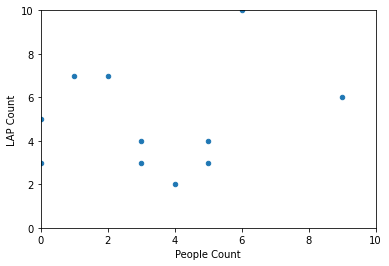

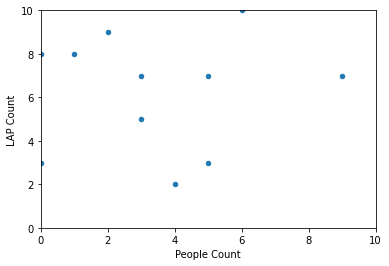

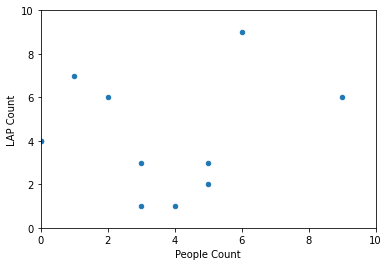

In [5]:
min_signal = -80

df1 = pd.read_csv("data/experiment3/tinkerboard1/tb1_2020-07-02_16:04:24.023892.csv")
df2 = pd.read_csv("data/experiment3/tinkerboard2/tb2_2020-07-02_16:04:30.999325.csv")
df4 = pd.read_csv("data/experiment3/tinkerboard4/tb3_2020-07-02_16:04:42.018970.csv")

def filter_and_plot(df, sensorname):
    df["timestamp"] = df["timestamp"].astype('datetime64[ns]')
    start_ts = df.iloc()[0]["timestamp"]
    df["timestamp"] = df["timestamp"] - start_ts
    df["timestamp"] = df["timestamp"] + actual_start_ts


    with open('data/experiment3/camera data/192.168.2.106_count_FIFTEEN_MINUTES.json') as f:
        camera_data = pd.DataFrame(list(map(lambda x: {"from": x["from"], "to": x["to"], "count": x["value"][0]["value"]},json.load(f)["content"]["element"][0]["measurement"])))
        camera_data["from"] = camera_data["from"].astype('datetime64[ns]')
        camera_data["to"] = camera_data["to"].astype('datetime64[ns]')

    minmaxts = df.groupby("LAP").agg({"timestamp": [np.min, np.max]})
    minmaxts["tsdiff"] = minmaxts["timestamp", "amax"] - minmaxts["timestamp", "amin"]
    minmaxts.sort_values("tsdiff", inplace=True)
    filter = (minmaxts["tsdiff"] > dt.timedelta(seconds=1)) & (minmaxts["tsdiff"] < dt.timedelta(hours=1))

    filtered_LAPs = minmaxts[filter].index
    # LAP_counts = df["LAP"].value_counts()
    # constrained_LAP_counts = LAP_counts[(LAP_counts > min_lap_count) & (LAP_counts < max_lap_count)]
    #
    # filtered_LAPs = constrained_LAP_counts.index

    filtered_df = df
    filtered_df = filtered_df[filtered_df["LAP"].isin(filtered_LAPs)]
    filtered_df = filtered_df[filtered_df["signal"] > min_signal]

    def get_lap_count_for_interval(row):
        start = row["from"]
        end = row["to"]
        filtered = filtered_df[(filtered_df["timestamp"] > start) & (filtered_df["timestamp"] < end)]
        unique_count = filtered["LAP"].nunique()
        row["lap_count"] = unique_count
        return row
    merged = camera_data.apply(get_lap_count_for_interval, axis=1)
    merged = merged[merged["lap_count"] > 0]

    # ax = merged.plot("from", "count")
    # merged.plot("from", "lap_count",ax=ax)
    print(f'sensor: {sensorname}')
    print(merged[["count", "lap_count"]].corr())

    print(f'shape laps: {filtered_LAPs.shape}')
    print(f'no people: {merged["count"].sum()}')

    ax = merged.plot("count", "lap_count", kind="scatter")
    ax.set_ylabel("LAP Count")
    ax.set_xlabel("People Count")
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=0, top=10)

    plt.savefig(f"lapcnt_vs_pplcnt_{sensorname}.png")


filter_and_plot(df1, "3")
filter_and_plot(df2, "1")
filter_and_plot(df4, "2")


In [66]:
minmaxts = df1.groupby("LAP").agg({"timestamp": [np.min, np.max]})
minmaxts["tsdiff"] = minmaxts["timestamp", "amax"] - minmaxts["timestamp", "amin"]
minmaxts.sort_values("tsdiff", inplace=True)

24
              count  lap_count
count      1.000000   0.139848
lap_count  0.139848   1.000000
no people: 38


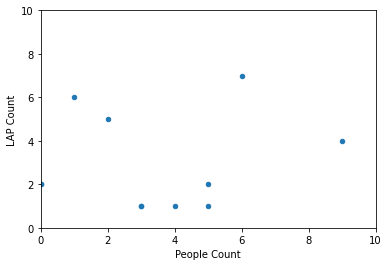

In [6]:
def filter_merge_plot(dfs):
    def adjust_start(df):
        df["timestamp"] = df["timestamp"].astype('datetime64[ns]')
        start_ts = df.iloc()[0]["timestamp"]
        df["timestamp"] = df["timestamp"] - start_ts
        df["timestamp"] = df["timestamp"] + actual_start_ts

    [adjust_start(df) for df in dfs]

    def filter_df(df):
        minmaxts = df.groupby("LAP").agg({"timestamp": [np.min, np.max]})
        minmaxts["tsdiff"] = minmaxts["timestamp", "amax"] - minmaxts["timestamp", "amin"]
        minmaxts.sort_values("tsdiff", inplace=True)
        filter = (minmaxts["tsdiff"] > dt.timedelta(seconds=1)) & (minmaxts["tsdiff"] < dt.timedelta(hours=1))
        filtered_LAPs = minmaxts[filter].index
        filtered_df = df
        filtered_df = filtered_df[filtered_df["LAP"].isin(filtered_LAPs)]
        filtered_df = filtered_df[filtered_df["signal"] > min_signal]
        return filtered_df

    f_dfs = [filter_df(df) for df in dfs]

    with open('data/experiment3/camera data/192.168.2.106_count_FIFTEEN_MINUTES.json') as f:
        camera_data = pd.DataFrame(list(map(lambda x: {"from": x["from"], "to": x["to"], "count": x["value"][0]["value"]},json.load(f)["content"]["element"][0]["measurement"])))
        camera_data["from"] = camera_data["from"].astype('datetime64[ns]')
        camera_data["to"] = camera_data["to"].astype('datetime64[ns]')

    all_merged = []
    def get_lap_count_for_interval(row):
        start = row["from"]
        end = row["to"]
        filtered = [(f_df[(f_df["timestamp"] > start) & (f_df["timestamp"] < end)]) for f_df in f_dfs]
        filtered_sets = [set(f_df["LAP"]) for f_df in filtered]
        merged = functools.reduce(lambda a, b: a & b, filtered_sets)
        all_merged.append(merged)
        unique_count = len(merged)
        row["lap_count"] = unique_count
        return row
    merged = camera_data.apply(get_lap_count_for_interval, axis=1)
    merged = merged[merged["lap_count"] > 0]

    all_laps = functools.reduce(lambda a, b: a | b, all_merged)
    print(len(all_laps))

    print(merged[["count", "lap_count"]].corr())

    print(f'no people: {merged["count"].sum()}')

    ax = merged.plot("count", "lap_count", kind="scatter")
    ax.set_ylabel("LAP Count")
    ax.set_xlabel("People Count")
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=0, top=10)

    plt.savefig("lapcnt_vs_pplcnt_merged.png")

filter_merge_plot([df1, df2, df4])

